# MNIST handwritten digit classification with CNNs

In this notebook, we'll train a convolutional neural network (CNN, ConvNet) to classify MNIST digits using **PyTorch**. 

First, the needed imports. 

In [49]:
%matplotlib inline

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

from PIL import Image, ImageOps

In [6]:
print('Using PyTorch version:', torch.__version__)
if torch.cuda.is_available():
    print('Using GPU, device name:', torch.cuda.get_device_name(0))
    device = torch.device('cuda')
else:
    print('No GPU found, using CPU instead.') 
    device = torch.device('cpu')

Using PyTorch version: 2.5.1+cu118
Using GPU, device name: NVIDIA RTX 500 Ada Generation Laptop GPU


In [23]:
#root_dir = os.path.join(os.getcwd(), 'data')
root_dir = os.getcwd()
root_dir

'D:\\playground\\field_island_presence'

#### Create custom dataset

class mydataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.annotations.iloc[idx, 1])
        image = Image.open(img_name)
        label = 1 if self.annotations.iloc[idx, 1] == 'present' else 0

        if self.transform:
            image = self.transform(image)

        return image, label

    def get_image_dimensions(self):
        dimensions = []
        for idx in range(len(self.annotations)):
            img_name = os.path.join(self.root_dir, self.annotations.iloc[idx, 1])
            image = Image.open(img_name)
            dimensions.append((img_name, image.size))
        return dimensions

In [54]:
class mydataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.annotations.iloc[idx, 1])
        image = Image.open(img_name)
        label = 1 if self.annotations.iloc[idx, 1] == 'present' else 0

        # Add zero padding to make the image size (3, 640, 640)
        image = self.pad_image(image)

        if self.transform:
            image = self.transform(image)

        return image, label

    def pad_image(self, image):
        # Ensure the image has 3 channels
        if image.mode != 'RGB':
            image = image.convert('RGB')
        
        # Calculate padding
        width, height = image.size
        left_padding = (640 - width) // 2
        top_padding = (640 - height) // 2
        right_padding = 640 - width - left_padding
        bottom_padding = 640 - height - top_padding
        
        # Add padding to the image
        padding = (left_padding, top_padding, right_padding, bottom_padding)
        padded_image = ImageOps.expand(image, padding)
        
        return padded_image

    def get_padded_image_dimensions(self):
        dimensions = []
        for idx in range(len(self.annotations)):
            img_name = os.path.join(self.root_dir, self.annotations.iloc[idx, 1])
            image = Image.open(img_name)
            padded_image = self.pad_image(image)
            dimensions.append((img_name, (3, 640, 640)))
        return dimensions

In [55]:
# Example usage
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = mydataset(csv_file='train.csv', root_dir='', transform=transform)
test_dataset = mydataset(csv_file='test.csv', root_dir='', transform=transform)

In [56]:
# Get the dimensions of each image file
test_image_dim = test_dataset.get_padded_image_dimensions()

# Print the dimensions of each image file
for img_name, dim in test_image_dim:
    print(f"Image: {img_name}, Dimensions: {dim}")

Image: .\data\test\absent\rgba_1002.tif, Dimensions: (3, 640, 640)
Image: .\data\test\absent\rgba_1003.tif, Dimensions: (3, 640, 640)
Image: .\data\test\absent\rgba_1013.tif, Dimensions: (3, 640, 640)
Image: .\data\test\absent\rgba_1018.tif, Dimensions: (3, 640, 640)
Image: .\data\test\absent\rgba_103.tif, Dimensions: (3, 640, 640)
Image: .\data\test\absent\rgba_108.tif, Dimensions: (3, 640, 640)
Image: .\data\test\absent\rgba_113.tif, Dimensions: (3, 640, 640)
Image: .\data\test\absent\rgba_120.tif, Dimensions: (3, 640, 640)
Image: .\data\test\absent\rgba_122.tif, Dimensions: (3, 640, 640)
Image: .\data\test\absent\rgba_125.tif, Dimensions: (3, 640, 640)
Image: .\data\test\absent\rgba_128.tif, Dimensions: (3, 640, 640)
Image: .\data\test\absent\rgba_136.tif, Dimensions: (3, 640, 640)
Image: .\data\test\absent\rgba_141.tif, Dimensions: (3, 640, 640)
Image: .\data\test\absent\rgba_142.tif, Dimensions: (3, 640, 640)
Image: .\data\test\absent\rgba_146.tif, Dimensions: (3, 640, 640)
Image:

In [57]:
batch_size = 10

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [58]:
next(iter(train_loader))

[tensor([[[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
           [-1.0000,  0.2549,  0.2314,  ...,  0.2235, -1.0000, -1.0000],
           [-1.0000,  0.2392,  0.2392,  ...,  0.2078, -1.0000, -1.0000],
           ...,
           [-1.0000,  0.2627,  0.2784,  ...,  0.2627, -1.0000, -1.0000],
           [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
           [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],
 
          [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
           [-1.0000,  0.2157,  0.1922,  ...,  0.2157, -1.0000, -1.0000],
           [-1.0000,  0.2000,  0.2000,  ...,  0.2000, -1.0000, -1.0000],
           ...,
           [-1.0000,  0.2235,  0.2392,  ...,  0.2314, -1.0000, -1.0000],
           [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
           [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],
 
          [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
           [-

## Convolutional neural network

Now we are ready to create a convolutional model. As before we use `nn.Sequential` to easily create a sequence of layers.

Here we use:

- [Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d), which operates on 2D matrices so we input the digit images directly to the model (no need to "flatten" at this point),
- [MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d) reduces the spatial dimensions, that is, makes the image smaller,
- Finally we flatten the image to a vector and add two linear layers.

All the [neural network building blocks defined in PyTorch can be found in the torch.nn documentation](https://pytorch.org/docs/stable/nn.html).

The output of the last layer should be normalized with softmax, but this is actually included implicitly in the loss function in PyTorch (see below).

In [73]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # Change input channels to 3
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(128 * 80 * 80, 128),  # Adjust the input size for the linear layer
            nn.ReLU(),
            nn.Linear(128, 10)
            #nn.Linear(128, 1),  # Output a single value per sample
            #nn.Sigmoid()  # Apply sigmoid activation for binary classification
        )

    def forward(self, x):
        return self.layers(x)

In [74]:
model = SimpleCNN().to(device)
print(model)

SimpleCNN(
  (layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=819200, out_features=128, bias=True)
    (11): ReLU()
    (12): Linear(in_features=128, out_features=10, bias=True)
  )
)


**Note:** one slightly tricky thing in the code above is that you have to know the input dimension for the first linear layer. This is the output of the `Conv2d` followed by the `MaxPool2d`. This can be reasoned as follows:

- the input to `Conv2d` will be 1x28x28 as the images have a single color channel (gray scale) and have a width by height of 28x28
- the output of `Conv2d` will be 32x26x26 as the color channels are replaced by the outputs of the 32 convolution kernels, and due the valid padding and kernel size of 3x3 a border of 1 pixel will be excluded
- `MaxPool2d` will remove every second pixel along each dimension, so we get 32x13x13=5408

If you are lazy you can also just guess something and run the code. The error message will tell you what size it expected to have!

## Learning

Now let's train the CNN model.

First we'll define the same functions as in the previous exercise. We've made a few minor additions:
- In the `train` function we added `tqdm` to print a nicer progress bar as the training will be a bit slower this time.
- We return the loss and accuracy so we can do some plotting

In [75]:
def correct(output, target):
    predicted_digits = output.argmax(1)                            # pick digit with largest network output
    correct_ones = (predicted_digits == target).type(torch.float)  # 1.0 for correct, 0.0 for incorrect
    return correct_ones.sum().item()                               # count number of correct ones


In [76]:
def train(data_loader, model, criterion, optimizer):
    model.train()

    num_batches = len(data_loader)
    num_items = len(data_loader.dataset)

    total_loss = 0
    total_correct = 0
    for data, target in tqdm(data_loader, total=num_batches):
        # Copy data and targets to GPU
        data = data.to(device)
        target = target.to(device)
        
        # Do a forward pass
        output = model(data)
        
        # Calculate the loss
        loss = criterion(output, target)
        total_loss += loss

        # Count number of correct digits
        total_correct += correct(output, target)
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    scheduler.step()
    train_loss = total_loss/num_batches
    accuracy = total_correct/num_items
    print(f"Average loss: {train_loss:7f}, accuracy: {accuracy:.2%}")
    return train_loss.item(), accuracy


In [77]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

This is a relatively complex model, so training is considerably slower than with MLPs. 

In [ ]:
%%time

losses = []
accuracies = []
epochs = 5
for epoch in range(epochs):
    print(f"Training epoch: {epoch+1}")
    loss, acc = train(train_loader, model, criterion, optimizer)
    losses.append(loss)
    accuracies.append(acc)

Training epoch: 1


  1%|          | 1/168 [01:00<2:49:44, 60.98s/it]

Let's plot how the loss and accuracy change over the epochs

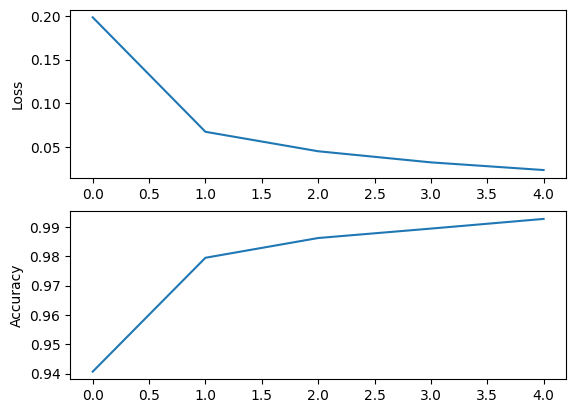

In [8]:
plt.subplot(2,1,1)
plt.plot(losses)
plt.ylabel("Loss")
plt.subplot(2,1,2)
plt.plot(accuracies)
plt.ylabel("Accuracy");

In [9]:
losses

[0.19852589070796967,
 0.06715552508831024,
 0.04481741413474083,
 0.03207051753997803,
 0.023258142173290253]

### Inference

Here we have the same `test` function as before.

In [10]:
def test(test_loader, model, criterion):
    model.eval()

    num_batches = len(test_loader)
    num_items = len(test_loader.dataset)

    test_loss = 0
    total_correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            # Copy data and targets to GPU
            data = data.to(device)
            target = target.to(device)
        
            # Do a forward pass
            output = model(data)
        
            # Calculate the loss
            loss = criterion(output, target)
            test_loss += loss.item()
        
            # Count number of correct digits
            total_correct += correct(output, target)

    test_loss = test_loss/num_batches
    accuracy = total_correct/num_items

    print(f"Testset accuracy: {100*accuracy:>0.1f}%, average loss: {test_loss:>7f}")

In [11]:
test(test_loader, model, criterion)

Testset accuracy: 98.6%, average loss: 0.050482


Let's take a look at the convolution weights of the Conv2D layer.

In [12]:
for i, module in enumerate(model.modules()):
    print(i, type(module))

0 <class '__main__.SimpleCNN'>
1 <class 'torch.nn.modules.container.Sequential'>
2 <class 'torch.nn.modules.conv.Conv2d'>
3 <class 'torch.nn.modules.activation.ReLU'>
4 <class 'torch.nn.modules.pooling.MaxPool2d'>
5 <class 'torch.nn.modules.flatten.Flatten'>
6 <class 'torch.nn.modules.linear.Linear'>
7 <class 'torch.nn.modules.activation.ReLU'>
8 <class 'torch.nn.modules.linear.Linear'>


In [14]:
model.modules

<bound method Module.modules of SimpleCNN(
  (layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Linear(in_features=5408, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=10, bias=True)
  )
)>

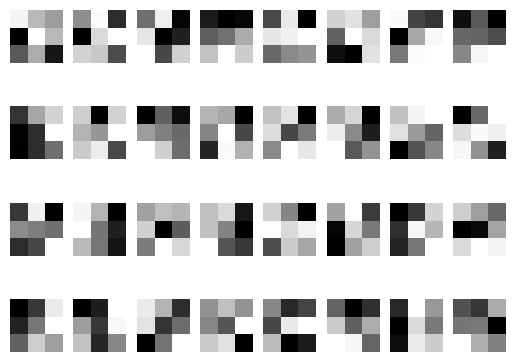

In [13]:
weights = [module for module in model.modules()][2].weight.data.numpy()

for i in range(weights.shape[0]):
    plt.subplot(4, 8, i+1)
    c = weights[i][0]
    c = c - np.min(c)
    c = c / np.max(c)
    plt.imshow(c, cmap='gray', interpolation='nearest')
    plt.axis('off')


## Task 1: A more complex CNN model

Your task is to try the same problem as above, but with two convolutional layers. The new model should have the following layers in order:

- Convolutional (`Conv2d`) layer with 32 units and 3x3 kernels, valid padding + ReLU activation
- Another identical convolutional layer + ReLU activation
- Max pooling (`MaxPool2d`) layer with 2x2 pooling size
- Dropout with 0.25 rate
- Flatten
- Dense layer with 128 units
- Dropout with 0.5 rate
- Dense output layer with 10 units

You can consult the [PyTorch documentation](https://pytorch.org/docs/stable/index.html), in particular all the [neural network building blocks can be found in the `torch.nn` documentation](https://pytorch.org/docs/stable/nn.html).

The code below is missing the model definition. You can copy any suitable layers from the example above.

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding='valid'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(32*13*13, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.layers(x)

model = SimpleCNN().to(device)
print(model)

In [43]:
class ComplexCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
           # TASK 1: ADD LAYERS HERE
            nn.Conv2d(1, 32, kernel_size=3, padding='valid'),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding='valid'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.25),
            nn.Flatten(),
            nn.Linear(32*12*12, 128),
            nn.Dropout(0.5),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.layers(x)


If you want to see an example answer, change the type of the cell below to "Code" in the menu bar above and then execute the cell. Execute the cell again to run the example code.

**Note:** in Google Colab you can [click here](https://github.com/csc-training/intro-to-dl/blob/master/day1/solutions/pytorch-mnist-cnn-example-answer.py) and copy the answer manually.

In [42]:
ex1_model = ComplexCNN()
print(ex1_model)

assert len(ex1_model.layers) > 0, "ERROR: You need to write the missing model definition above!"
ex1_model = ex1_model.to(device)

ComplexCNN(
  (layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.25, inplace=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=4608, out_features=128, bias=True)
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [22]:
ex1_criterion = nn.CrossEntropyLoss()
ex1_optimizer = torch.optim.Adam(ex1_model.parameters())

In [29]:
%%time

losses = []
accuracies = []
epochs = 5
for epoch in range(epochs):
    print(f"Epoch: {epoch+1} ...")
    loss, acc = train(train_loader, ex1_model, ex1_criterion, ex1_optimizer)
    losses.append(loss)
    accuracies.append(acc)

Epoch: 1 ...


100%|██████████| 1875/1875 [00:16<00:00, 110.69it/s]


Average loss: 2.307325, accuracy: 8.73%
Epoch: 2 ...


100%|██████████| 1875/1875 [00:15<00:00, 118.67it/s]


Average loss: 2.307347, accuracy: 8.84%
Epoch: 3 ...


100%|██████████| 1875/1875 [00:15<00:00, 120.08it/s]


Average loss: 2.307735, accuracy: 8.73%
Epoch: 4 ...


100%|██████████| 1875/1875 [00:15<00:00, 120.24it/s]


Average loss: 2.307775, accuracy: 8.67%
Epoch: 5 ...


100%|██████████| 1875/1875 [00:16<00:00, 117.04it/s]

Average loss: 2.307807, accuracy: 8.57%
CPU times: user 26min 36s, sys: 916 ms, total: 26min 37s
Wall time: 1min 20s


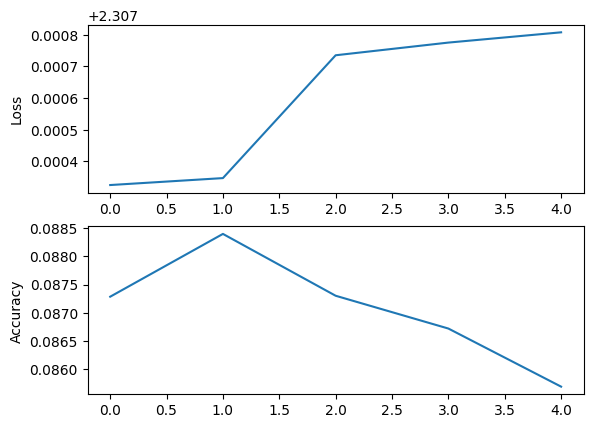

In [30]:
plt.subplot(2,1,1)
plt.plot(losses)
plt.ylabel("Loss")
plt.subplot(2,1,2)
plt.plot(accuracies)
plt.ylabel("Accuracy");

In [31]:
test(test_loader, ex1_model, ex1_criterion)

Testset accuracy: 6.1%, average loss: 2.306752


## Task 2: Tune training parameters

Try to improve the classification accuracy, in particular by trying different optimizers and playing with the parameters of the training process.

See optimizers available in PyTorch here: <https://pytorch.org/docs/stable/optim.html#algorithms>

You can take the model created in Task 1 as a starting point. Below is a code example which you can modify.

If you wish to change the batch size, you need to re-define the data loaders.

In [36]:
batch_size = 16

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [44]:
#import torch.optim.lr_scheduler as lr_scheduler

ex2_model = ComplexCNN().to(device)

ex2_criterion = nn.CrossEntropyLoss()
ex2_optimizer = torch.optim.Adam(ex2_model.parameters())

#lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0
#ex2_scheduler = lr_scheduler.StepLR(ex2_optimizer, step_size=3, gamma=0.5)

epochs = 10
for epoch in range(epochs):
    print(f"Epoch: {epoch+1} ...")
    train(train_loader, ex2_model, ex2_criterion, ex2_optimizer)

Epoch: 1 ...


100%|██████████| 3750/3750 [00:24<00:00, 153.74it/s]


Average loss: 0.167358, accuracy: 94.89%
Epoch: 2 ...


100%|██████████| 3750/3750 [00:24<00:00, 155.03it/s]


Average loss: 0.081752, accuracy: 97.52%
Epoch: 3 ...


100%|██████████| 3750/3750 [00:24<00:00, 155.61it/s]


Average loss: 0.064887, accuracy: 98.00%
Epoch: 4 ...


100%|██████████| 3750/3750 [00:24<00:00, 156.16it/s]


Average loss: 0.054651, accuracy: 98.29%
Epoch: 5 ...


100%|██████████| 3750/3750 [00:23<00:00, 156.79it/s]


Average loss: 0.048754, accuracy: 98.48%
Epoch: 6 ...


100%|██████████| 3750/3750 [00:24<00:00, 155.51it/s]


Average loss: 0.043432, accuracy: 98.66%
Epoch: 7 ...


100%|██████████| 3750/3750 [00:24<00:00, 155.57it/s]


Average loss: 0.040575, accuracy: 98.74%
Epoch: 8 ...


100%|██████████| 3750/3750 [00:24<00:00, 154.33it/s]


Average loss: 0.039604, accuracy: 98.72%
Epoch: 9 ...


100%|██████████| 3750/3750 [00:24<00:00, 153.69it/s]


Average loss: 0.035503, accuracy: 98.84%
Epoch: 10 ...


100%|██████████| 3750/3750 [00:24<00:00, 153.35it/s]


Average loss: 0.033504, accuracy: 98.98%
Epoch: 11 ...


100%|██████████| 3750/3750 [00:24<00:00, 153.46it/s]


Average loss: 0.033609, accuracy: 98.94%
Epoch: 12 ...


100%|██████████| 3750/3750 [00:25<00:00, 149.64it/s]


Average loss: 0.031334, accuracy: 98.95%
Epoch: 13 ...


100%|██████████| 3750/3750 [00:24<00:00, 153.26it/s]


Average loss: 0.030863, accuracy: 99.00%
Epoch: 14 ...


100%|██████████| 3750/3750 [00:24<00:00, 153.28it/s]


Average loss: 0.029335, accuracy: 99.06%
Epoch: 15 ...


100%|██████████| 3750/3750 [00:24<00:00, 153.16it/s]

Average loss: 0.029416, accuracy: 99.07%


In [45]:
test(test_loader, ex2_model, ex2_criterion)

Testset accuracy: 99.1%, average loss: 0.034767


## Extra: View model summary

One way to view more information about the model is to use an external package such as [Torchinfo](https://github.com/TylerYep/torchinfo). It is not installed in the standard Pytorch module in LUMI, so you need to install it using pip:

In [49]:
!pip install torchinfo

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [50]:
from torchinfo import summary

ModuleNotFoundError: No module named 'torchinfo'

In [17]:
summary(model, input_size=(batch_size, 1, 28, 28), 
        col_names=["input_size", "output_size", "kernel_size", "num_params"])

NameError: name 'summary' is not defined